In [1]:
pip install --user u8darts

Note: you may need to restart the kernel to use updated packages.


In [ ]:
https://towardsdatascience.com/temporal-loops-intro-to-recurrent-neural-networks-for-time-series-forecasting-in-python-b0398963dc1f

In [2]:
import pandas as pd
import numpy as np

In [3]:
pip install u8darts[fbprophet]

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install u8darts[pmdarima]

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install u8darts[torch]

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: frozenlist>=1.1.1 in c:\programdata\anaconda3\lib\site-packages (from aiohttp->fsspec[http]!=2021.06.0,>=2021.05.0->pytorch-lightning>=1.5.0->u8darts[torch]) (1.3.0)



In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = "19590101"   # period at which to split training and validation dataset

In [9]:
pip install u8darts[all]

  Running setup.py clean for prophet
Failed to build prophet
    Running setup.py install for prophet: started
    Running setup.py install for prophet: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sn3028\\AppData\\Local\\Temp\\pip-install-c8necwhl\\prophet_01b62e97004a450d8a470381a9791faa\\setup.py'"'"'; __file__='"'"'C:\\Users\\sn3028\\AppData\\Local\\Temp\\pip-install-c8necwhl\\prophet_01b62e97004a450d8a470381a9791faa\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\sn3028\AppData\Local\Temp\pip-wheel-5lfv6oby'
       cwd: C:\Users\sn3028\AppData\Local\Temp\pip-install-c8necwhl\prophet_01b62e97004a450d8a470381a9791faa\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\prophet
  creating build\lib\prophet\stan_model
  Traceback (most recent call last):
    File "<stri

In [10]:

EPOCH = 300       # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [4]:
## load data
ts = AirPassengersDataset().load()

series = ts  
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [5]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


In [6]:

# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [17]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

NameError: name 'ts' is not defined

In [16]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

NameError: name 'series' is not defined

In [19]:

# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, df, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

In [ ]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

In [20]:

# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [21]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [22]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [11]:
import pandas as pd
df = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
df=df.set_index("date")
d=["log_gdp", "d3m_tbill", "dfed_fund", "dcpi", "d10y_bond"]
df=df.drop(d, axis=1)
df=df.iloc[4:,]
df

,dlog_gdp_yoy,unemp,3m_tbill,fedfund,cpi,manu_utilization,10y_bond
date,,,,,,,
1/1/1973,0.031658,4.933333,5.700000,6.536667,6.603333,87.702233,6.603333
4/1/1973,0.026614,4.933333,6.603333,7.816667,6.806667,87.696100,6.806667
7/1/1973,0.020241,4.800000,8.323333,10.560000,7.206667,87.502633,7.206667
10/1/1973,0.017133,4.766667,7.500000,9.996667,6.753333,88.285867,6.753333
1/1/1974,0.002765,5.133333,7.616667,9.323333,7.053333,86.648667,7.053333
...,...,...,...,...,...,...,...
10/1/2020,-0.009941,6.766667,0.093333,0.090000,0.863333,74.182667,0.863333
1/1/2021,0.002369,6.200000,0.050000,0.080000,1.316667,74.733533,1.316667
4/1/2021,0.050096,5.900000,0.026667,0.070000,1.593333,75.761367,1.593333


In [23]:
from darts import TimeSeries
import pandas as pd
df = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
d=["log_gdp", "d3m_tbill", "dfed_fund", "dcpi", "d10y_bond"]
df=df.drop(d, axis=1)
df=df.iloc[4:,]
df=TimeSeries.from_dataframe(df, 'date')
df

<TimeSeries (DataArray) (date: 196, component: 7, sample: 1)>
array([[[3.16584180e-02],
        [4.93333333e+00],
        [5.70000000e+00],
        ...,
        [6.60333333e+00],
        [8.77022333e+01],
        [6.60333333e+00]],

       [[2.66135790e-02],
        [4.93333333e+00],
        [6.60333333e+00],
        ...,
        [6.80666667e+00],
        [8.76961000e+01],
        [6.80666667e+00]],

       [[2.02414510e-02],
        [4.80000000e+00],
        [8.32333333e+00],
        ...,
...
        ...,
        [1.59333333e+00],
        [7.57613667e+01],
        [1.59333333e+00]],

       [[2.09681890e-02],
        [5.10000000e+00],
        [4.66666670e-02],
        ...,
        [1.32333333e+00],
        [7.63843667e+01],
        [1.32333333e+00]],

       [[2.34841570e-02],
        [4.23333333e+00],
        [5.33333330e-02],
        ...,
        [1.53666667e+00],
        [7.73605667e+01],
        [1.53666667e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 1973-01-01 1973-04-01 ... 2021-10-01
  * component  (component) object 'dlog_gdp_yoy' 'unemp' ... '10y_bond'
Dimensions without coordinates: sample

In [24]:
FC_N = 16               # forecast periods
FC_START = "20180101"   # period at which to split training and validation dataset
# split training vs test dataset
train, val = df['dlog_gdp_yoy'].split_after(pd.Timestamp(FC_START))

In [25]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
df_trf = trf.transform(df)

In [29]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=df['dlog_gdp_yoy'].freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

NameError: name 'series' is not defined

In [30]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, df_trf, train_trf, val_trf) for flv in flavors]

NameError: name 'periodicity' is not defined

In [ ]:
series = df  
df = df.pd_dataframe()
df
df.index = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df.index, format = '%m/%d/%Y').strftime('%Y/%m/%d')
gdp=ts.to_frame()
## load data
ts = AirPassengersDataset()
type(ts)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))


In [31]:
df = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
df=df[['date','dlog_gdp_yoy']].iloc[4:,]
df.set_index('date')

,dlog_gdp_yoy
date,
1/1/1973,0.031658
4/1/1973,0.026614
7/1/1973,0.020241
10/1/1973,0.017133
1/1/1974,0.002765
...,...
10/1/2020,-0.009941
1/1/2021,0.002369
4/1/2021,0.050096


In [32]:
df=TimeSeries.from_dataframe(df, 'date')
df

<TimeSeries (DataArray) (date: 196, component: 1, sample: 1)>
array([[[ 0.03165842]],

       [[ 0.02661358]],

       [[ 0.02024145]],

       [[ 0.01713253]],

       [[ 0.00276534]],

       [[-0.00090609]],

       [[-0.00274034]],

       [[-0.00853225]],

       [[-0.0101012 ]],

       [[-0.00804007]],

...

       [[ 0.00995343]],

       [[ 0.01101791]],

       [[ 0.00273086]],

       [[-0.04135843]],

       [[-0.01272489]],

       [[-0.00994062]],

       [[ 0.00236902]],

       [[ 0.05009611]],

       [[ 0.02096819]],

       [[ 0.02348416]]])
Coordinates:
  * date       (date) datetime64[ns] 1973-01-01 1973-04-01 ... 2021-10-01
  * component  (component) object 'dlog_gdp_yoy'
Dimensions without coordinates: sample

In [33]:
series=df

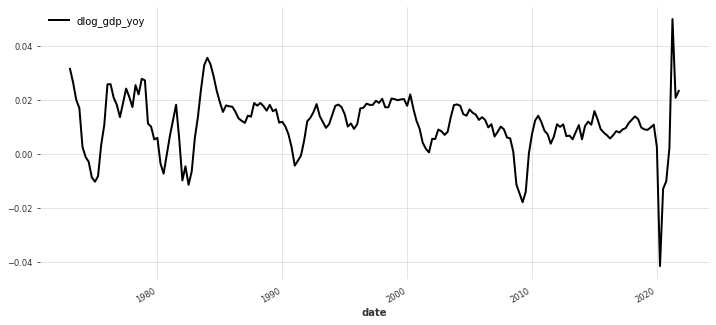

In [34]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [35]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(df, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 22.0
periodicity (~years) : 1.8


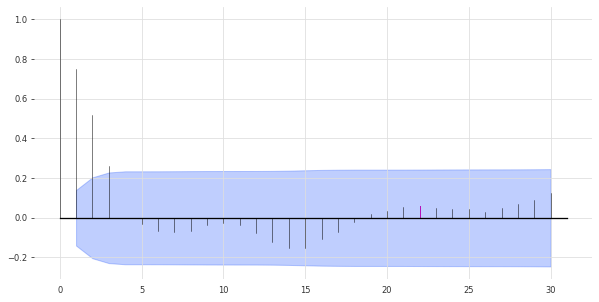

In [38]:
# plot its autocorrelation function
plot_acf(df, periodicity, max_lag=30)

In [52]:
FC_N = 16               # forecast periods
FC_START = "20180101"   # period at which to split training and validation dataset
# split training vs test dataset
train, val = df.split_after(pd.Timestamp(FC_START))

In [53]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
df_trf = trf.transform(df)

In [54]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=df.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))


In [71]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, df_trf, train_trf, val_trf) for flv in flavors]


beginning the training of the LSTM RNN:


ValueError: __len__() should return >= 0

In [70]:

# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, df, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=180,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, df, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, df)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

In [57]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [58]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [59]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

#### Keras Simple RNN Model

In [76]:
pip install Keras


Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=403dfff4005f53167822c1b45dc3cceef0564cf9c8955e1cfdb318bd372747d6
  Stored in directory: c:\users\sn3028\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [163]:
df = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
df=df[['dlog_gdp_yoy']].iloc[4:,]
df

,dlog_gdp_yoy
4,0.031658
5,0.026614
6,0.020241
7,0.017133
8,0.002765
...,...
195,-0.009941
196,0.002369
197,0.050096
198,0.020968


In [164]:
values=df.values
train,test = values[0:180,:], values[180:,:]

In [165]:
step=4
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [166]:
# convert into dataset matrix
def convertToMatrix(df, step):
 X, Y =[], []
 for i in range(len(df)-step):
  d=i+step  
  X.append(df[i:d,])
  Y.append(df[d,])
 return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [167]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape



(180, 1, 4)

In [168]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=16, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 16)                336       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/100
12/12 - 1s - loss: 4.4547e-05 - 553ms/epoch - 46ms/step
Epoch 2/100
12/12 - 0s - loss: 3.3690e-05 - 10ms/epoch - 834us/step
Epoch 3/100
12/12 - 0s - loss: 2.8610e-05 - 11ms/epoch - 914us/step
Epoch 4/100
12/12 - 0s - loss: 2.8412e-05 - 9ms/epoch - 750us/step
Epoch 5/100
12/12 - 0s - loss: 2.7896e-05 - 10ms/epoch - 828us/step
Epoch 6/100
12/12 - 0s - loss: 2.6811e-05 - 10ms/epoch - 831us/step
Epoch 7/100
12/12 - 0s - loss: 2.5037e-05 - 9ms/epoch - 748us/step
Epoch 8/100
12/12 - 0s - loss: 2.2019e-05 - 9ms/epoch - 748us/step
Epoch 9/100
12/12 - 0s - loss: 2.8397e-05 - 10ms/epoch - 829us/step
Epoch 10/100
12/12 - 0s - loss: 2.4925e-05 - 11ms/epoch - 914us/step
Epoch 11/100
12/12 - 0s - loss: 2.7974e-05 - 9ms/epoch - 748us/step
Epoch 12/100
12/12 - 0s - loss: 2.6350e-05 - 10ms/epoch - 831us/step
Epoch 13/100
12/12 - 0s - loss: 2.3149e-05 - 9ms/epoch - 750us/step
Epoch 14/100
12/12 - 0s - loss: 2.5992e-05 - 10ms/epoch - 831us/step
Epoch 15/100
12/12 - 0s - loss: 2.2364e-05 - 10m

In [170]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)


2.6405201424495317e-05


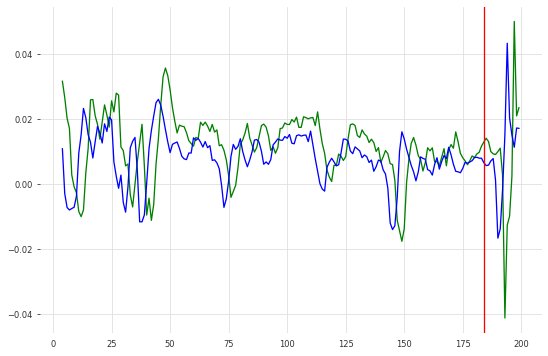

In [184]:
index = df.index.values
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(index,df, c="g")
plt.plot(index,predicted,  c="b")
plt.axvline(df.index[180], c="r")
plt.show() 

In [180]:
date=pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
date=date['date'].iloc[4:,]
date

4       1/1/1973
5       4/1/1973
6       7/1/1973
7      10/1/1973
8       1/1/1974
         ...    
195    10/1/2020
196     1/1/2021
197     4/1/2021
198     7/1/2021
199    10/1/2021
Name: date, Length: 196, dtype: object

In [179]:
date=date.tolist()

AttributeError: 'list' object has no attribute 'tolist'